# <u><b>0 - Préambule au code</b></u>

## <b><u>0.1 - Ensemble des variables à modifier en début d'exécution du Notebook :</u></b>
!!! On attire l'attention du lecteur/utilisateur sur les variables ci dessous :
- <b>Les chemins d'accès de données :</b> Ils sont définis localement, et depuis peu de façon relative au répertoire contenant ce notebook. Le lecteur/utilisateur est libre de les modifier par rapport à son propre environnement, mais il faudra alors veiller à rendre cette modification cohérence avec le bon accès aux fichiers présents ci-dessous dans les répertoires <b>../Cache_fichiers/</b>, <b>../Figures/</b>, etc.
- <b>Les booléens d'activation/désactivation :</b> Attention, ces booléens (selon qu'ils prennent True ou False) activent (ou désactivent) des fonctions telles que la sauvegarde en local de fichiers créés à partir de données calculées dans ce notebook, la sauvegarde en local de figures, etc.
- <b>Le booléen<i>avec colab</i> :</b> A passer sur True si on utilise le notebook depuis google colab pour qu'il puisse se connecter au drive et avoir accès aux données qui y sont stockées
- <b>La variable <i>dossiers_b2d_chiens</i> :</b> Permet de choisir entre l'une des deux base de données (13 races et 28 races, respectivement).

In [1]:
# Booléen prioritaire : on exécute le notebook avec Google Collab, vari ou faux !!!
avec_colab = False
if avec_colab :
    from google.colab import drive
    drive.mount('/content/drive/')
# Jeu de données sur lequel on travaille
dossiers_b2d_chiens = [
    "150_dogs_per_race/", 
    "150_dogs_per_race+/"
][1]

In [2]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
installation = False

### Tout ce qui concerne la base de données
# Chemin de données vers la base de données
if avec_colab:
    #"/content/drive/My Drive/P6/B2D/Images/"
    path_b2d = "/content/drive/My Drive/P7/Notebook/"+dossiers_b2d_chiens
else :
    #"C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P6/B2D/
    #"dogs_standford_dataset"
    #"../../../P6/B2D/Images/"
    path_b2d = dossiers_b2d_chiens
    
### Tout ce qui concerne les figures
# Sauvegarde des figures 
sauvegarde_figure = True 
if sauvegarde_figure :
    prefixe = dossiers_b2d_chiens[:-1]+'_'
    # chemin de données vers répertoire de stockage
    if avec_colab :
        path_fig = "/content/drive/My Drive/P7/Figures/"+prefixe
    else :
        path_fig = "../Figures/"+prefixe

### Tout ce qui concerne le cache des fichiers (pour ne pas avoir à refaire tous les calculs systématiquement)
# Sauvegarde des figures 
sauvegarde_fichiers = True 
if sauvegarde_fichiers :
    prefixe = dossiers_b2d_chiens[:-1]+'_'
    # Chemin de données vers répertoire de stockage
    if avec_colab :
        path_cache_output = "/content/drive/My Drive/P7/Cache_fichiers/"+prefixe
    else :
        path_cache_output = "../Cache_fichiers/"+prefixe

### Autres
# Booléens d'activation de la mise de côté des calculs longs, au profit du chargement des résultats de ces calculs, préalablement sauvegardés en local
court_circuiter = True

## <u><b>0.2 - Installation éventuelle de librairies python :</b></u>
!!! Sautez cette étape si vous les avez déjà sur votre ordinateur, en mettant le booléen <i>installation</i> à <i>False</i>.

In [3]:
if installation :
    !pip install Pillow
    !pip install transformers
    !pip install tensorflow

## <u><b>0.3 - Importations de librairies/modules/fonctions python :</b></u>

In [4]:
import os
### Quelques classiques des notebooks scientifiques
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from seaborn import heatmap
### Traitement de texe
from re import split
### Mesure du temps
from tqdm import tqdm
from time import time
### Pickle
import pickle
### PIL
from PIL import Image

In [5]:
### Keras
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy
from tensorflow.config import list_physical_devices as lpd
from tensorflow.keras.mixed_precision import global_policy, set_global_policy

In [6]:
### Transformers
from transformers import ViTFeatureExtractor
from transformers import TFViTForImageClassification, create_optimizer
from transformers import DefaultDataCollator

In [7]:
### datasets
import datasets

## <u><b>0.4 - Définition de constantes personnelles :</b></u>

In [8]:
### On détermine un entier qui servira à gêler le random state au sein des différentes fonctions
rgn = 420

In [9]:
### On bloque le hasrd de numpy et de tensorflow.keras
np.random.seed(rgn)
set_random_seed(rgn)

In [10]:
# Liste des répertoires nommés selon le schéma "identifiant_chien"
list_dir = np.asarray(os.listdir(path=path_b2d))# + 'Images'))
# Dictionnaire qui associe [identifiant, chien] à chaque indice de la liste des répertoire
n_idchiens = {
    n: split(string=list_dir[n], pattern='-') for n in range(len(list_dir))
}

In [11]:
# Modèle pré-entraîné qu'on veut pour la nouvelle méthode (ViT)
model_id = "google/vit-base-patch16-224-in21k"
# On charge l'extracteur de features associé au modèle pré-entraîné
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

## <u><b>0.5 - Définition de fonctions personnelles :</b></u>

Les 3 fonctions ci-dessous ne sont pas de moi, je ne me les approprie pas ! Elles viennent d'une discussion publique sur <i>Stackoverflow</i> (https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets), et servent lors de la re-spération du <i>data set</i> en jeux d'entraînement et de test, lors de la section consacrée à la construction de notre propre CNN.

In [12]:
def create_image_folder_dataset(root_path):
    """creates `Dataset` from image folder structure"""
    # get class names by folders names
    _CLASS_NAMES= os.listdir(root_path)
    # defines `datasets` features`
    features=datasets.Features({
        "img": datasets.Image(),
        "label": datasets.features.ClassLabel(names=_CLASS_NAMES)
    })
    # temp list holding datapoints for creation
    img_data_files=[]
    label_data_files=[]
    # load images into list for creation
    for img_class in os.listdir(root_path):
        for img in os.listdir(os.path.join(root_path,img_class))[:148]:
            path_=os.path.join(root_path,img_class,img)
            img_data_files.append(path_)
            label_data_files.append(img_class)
    # create dataset
    ds = datasets.Dataset.from_dict(
        {"img":img_data_files,"label":label_data_files},
        features=features)
    return ds

In [13]:
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

In [14]:
def is_test(x, y):
    """Fonction qui renvoit un booléen True si son entrée x est un multiple de 4.
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return x % 4 == 0
###
def is_train(x, y):
    """Fonction qui renvoit un booléen True si son entrée x n'est pas un multiple de 4. 
    Elle prend deux arguments car x,y = enumerate(dataset), par anticipation de la façon dont est écrit le code en section III.

    Arguments de cette fonction :
    x -- entier, issu de la fonction enumerate
    y -- objet python en train d'être enumérer"""
    return not is_test(x, y)
### Fonction lambda adaptée à la restitution d'un dataset après affectation à l'un des deux jeux de test ou d'entraînement grâce aux fonctions ci-dessus
recover = lambda x,y: y

In [15]:
def model_fit(X_train, X_val, model_compile, nb_epochs, num_verbose, tab_callbacks):
    """Fonction qui réalise le fitting d'un objet de type Sequential ou Model du module keras de la librairie tensorflow, et mesure la durée de cet entraînement.

    Arguments de cette fonction :
    X_train -- dataset correspondant au jeu d'entraînement
    X_val -- dataset correspondant au jeu de validation
    model_compile -- objet de type Sequential ou Model, précédemment compilé
    nb_epochs -- entier, nombre d'itération -epoch- à faire lors de l'entraînement
    num_verbose -- entier, valeur de l'hyper-paramètre verbose de la fonction fit qui gère l'affichage de la progression de l'entraînement
    tab_callbacks -- liste d'objet de type Callback du module keras de la librairie tensorflow"""
    # Initialisatin de la mesure du temps
    t0 = time()
    # Entraînement/validation croisée
    modele_info = model_compile.fit(X_train, epochs=nb_epochs, validation_data=X_val, verbose=num_verbose, callbacks=tab_callbacks)
    # Mesure du temps d'entraînement
    delta_t = time()-t0
    print(f'Temps d`entraînement : {delta_t : >.1f} secondes')
    return model_compile, modele_info, delta_t

In [16]:
def plot_loss_score(model_info, model_eff, tab_X_test, tab_label, titre):
    """Fonction qui réalise l'affichage graphique de l'évolution temporelle de la fonction de perte, et du score de précision, lors de l'entraînement.

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné (model_info = model_eff.fit()), permettant l'accès à un historique
    model_eff-- objet de type Sequential ou Model précédemment compilé et entraîné
    tab_X_test -- liste de datasets correspondant à des de jeux de test
    tab_label -- liste de labels correspondant à ces jeux de test
    titre -- chaîne de caractère, titre du graphe"""
    ### Varibales adaptées aux performances sur les différents jeux
    # une liste de tableaux de performances sur les jeux de test, et mesure du temps nécessaire
    t0 = time()
    perf_test = [model_eff.evaluate(X_test) for X_test in tab_X_test] #[model_eff.evaluate(X_test, y_test) for (X_test, y_test) in zip(tab_X_test, tab_y_test)] 
    delta_t = time()-t0
    print(f'Temps d`évaluation : {delta_t : >.1f} secondes')
    # un dictionnaire de l'historique sur validation, la liste des métriques, et la liste des itérations
    dico, metric, epoch = model_info.history, model_info.model.metrics_names, model_info.epoch
    ### Graphe
    plt.figure('Performances '+titre, figsize=(7*len(metric), 7)), plt.clf()
    for i in range(0, len(metric)):
        axe = plt.subplot(1, len(metric), i+1)
        # metric n° i = f(epochs)
        axe.set_title(titre+f'\n{metric[i]} = f(Epochs)', fontsize=15, fontweight='bold') 
        axe.set_ylabel(metric[i], fontsize=12), axe.set_xlabel('Epochs', fontsize=12)
        axe.plot(epoch, dico[metric[i]], label='train set')
        axe.plot(epoch, dico['val_'+metric[i]], label='val set')
        # On complète avec les perf de la métrique courante sur les jeux de test
        for perf, label in zip(perf_test, tab_label):
            axe.plot([epoch[-1]+1], perf[i], marker='+', markersize=15, label=label+'test set')
        # Legendes
        axe.legend(loc='best')
    return perf_test[0], delta_t

In [17]:
def pickle_save(object_to_save, suffix_title):
    """Fonction qui sauvegarde un objet en local grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    object_to_save -- objet python à sauver
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode écriture de l'objet à sauvegarder dans le répertoire pointé par abs_path_cache_output
    file_pickel_ab = open(file=path_cache_output+suffix_title,mode='wb')
    # sauvegarde effective
    pickle.dump(object_to_save, file_pickel_ab)
    # fermeture du mode écriture
    file_pickel_ab.close()
    del file_pickel_ab

In [18]:
def pickle_load(suffix_title):
    """Fonction qui charge un objet sauvegardé localement, grâce à des fonctions de la librairie pickle

    Arguments de cette fonction :
    suffix_title -- chaîne de caractère, titre de la sauvegarde en local, nécessite que la variable de chemin de données path_cache_output ait été définie avant"""
    # on ouvre le mode lecture de l'objet rangé dans le répertoire pointé par abs_path_cache_output
    file_pickel_rb = open(file=path_cache_output+suffix_title,mode='rb')
    # chargement effectif
    objet = pickle.load(file_pickel_rb)
    # fermeture du mode lecture
    file_pickel_rb.close()
    del file_pickel_rb
    return objet

In [19]:
def dict_model(model_info, tps_info, model_eval, tps_eval, nb_train_param, model_title):
    """Fonction qui crée un dictionnaire analogue à l'historique d'un Sequential/Model déjà entraîné

    Arguments de cette fonction :
    model_info -- objet de type Sequential ou Model, défini comme un modele précédemment compilé et entraîné, permettant l'accès à un historique
    tps_info -- durée de l'entraînement
    model_eval-- objet de type Sequential ou Model précédemment compilé et entraîné et après avoir subbit une évaluation
    tps_eval -- durée de l'évaluation
    tab_label -- liste de labels correspondant à ces jeux de test
    model_title -- chaîne de caractère, titre sous lequel on veut sauvegarder le modèle"""
    model_dict = {key : model_info.history[key] for key in model_info.history.keys()}
    model_dict['test_loss'], model_dict['test_accuracy'], model_dict['test_top-3-accuracy'] = model_eval[0], model_eval[1], model_eval[2]
    model_dict['train_time'], model_dict['test_time'], model_dict['nb_train_param'] = tps_info, tps_eval, nb_train_param
    if sauvegarde_fichiers :
        pickle_save(object_to_save=model_dict, suffix_title=model_title)

# <u><b>I - ViT</b></u>

## <u><b>I.A - Données de travail</b></u>

### <u><b>I.A.1 - Chargement de données</b></u>

In [20]:
all_ds = create_image_folder_dataset(path_b2d)

### <u><b>I.A.2 - Création des jeux d'entraînement, de validation et de test</b></u>

#### <u><b>a) Création des jeux d'entraînement et de test</b></u>

In [21]:
# Jeu de test (1 image toutes les 4 images)
test_ds = all_ds.filter(
    lambda example, idx: idx% 4 == 0, with_indices=True#, batched=False, batch_size=None
)

  0%|          | 0/5 [00:00<?, ?ba/s]

In [22]:
test_path_files = test_ds.to_pandas()['img'].apply(lambda x : x['path'])

In [23]:
# Jeu d'entraînement (les 3 autres images complémentaires)
train_ds = all_ds.filter(
    lambda example, idx: idx% 4 > 0, with_indices=True#, batched=False, batch_size=None
)

  0%|          | 0/5 [00:00<?, ?ba/s]

#### <u><b>b) Création du jeux de validation (et re-génération du jeu d'entraînement)</b></u>

In [24]:
# Jeu de validation (1 image toutes les 4 images du train set)
val_ds = train_ds.filter(
    lambda example, idx: idx% 4 == 0, with_indices=True#, batched=False, batch_size=None
)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [25]:
# Jeu d'entraînement (les 3 autres images  de l'ancien train set)
train_ds = train_ds.filter(
    lambda example, idx: idx% 4 > 0, with_indices=True#, batched=False, batch_size=None
)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [26]:
del all_ds

## <u><b>I.B - Pré-traitements</b></u>

### <u><b>I.B.1 - Sans modifications des pixels</b></u>

In [27]:
# Mélange aléatoire des images au sein des jeux 
test_ds = test_ds.shuffle(seed=rgn)
train_ds = train_ds.shuffle(seed=rgn)
val_ds = val_ds.shuffle(seed=rgn)

In [28]:
# Renommer une colonne pour appliquer .to_tf_dataset par la suite
test_ds = test_ds.rename_column("label", "labels")
train_ds = train_ds.rename_column("label", "labels")
val_ds = val_ds.rename_column("label", "labels")

In [29]:
# Liste des étiquettes de chaque image (sous forme de labels)
img_class_labels = [
    n_idchiens[n][1] for n in range(len(list_dir))
]

### <u><b>I.B.2 - Extraction des <i>features</i></b></u>

In [30]:
# On lui affiche des propriétés en l'état
feature_extractor.get_feature_extractor_dict(model_id)

({'do_normalize': True,
  'do_resize': True,
  'image_mean': [0.5, 0.5, 0.5],
  'image_std': [0.5, 0.5, 0.5],
  'size': 224},
 {})

In [31]:
# Pre-traitement par extraction de features
test_ds_prepro_vit = test_ds.map(process, batched=True)#, batched=False)#
train_ds_prepro_vit = train_ds.map(process, batched=True)#, batched=False)#
val_ds_prepro_vit = val_ds.map(process, batched=True)#, batched=False)#

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
del test_ds, train_ds, val_ds

## <u><b>I.C - <i>Fine-tuning</i> du modèle pré-entraîné (avec Keras) :</b></u>

### <u><b>I.C.1 - Etapes préparatoires</b></u>

#### <u><b>a) Création de dictionnaires de correspondance <i>integer</i>-<i>lables</i></b></u>

In [33]:
# Dictionnaire qui a chaque entier associe une étiquette
id2label = {str(i): label for i, label in enumerate(img_class_labels)}
# Dictionnaire inverse
label2id = {v: k for k, v in id2label.items()}

#### <u><b>b) Initialisation d'hyper-paramètres</b></u>

In [34]:
### Initialisation de plusieurs HP
# Nombre d'epochs [itérations]
num_train_epochs = 5
# Taille des batchs
batch_size = 32
# Taux d'apprentissage
learning_rate = 3e-5
# Coef de la RMS(poids), terme supl. de L(y_true, y_pred)
weight_decay_rate=0.01
num_warmup_steps=0

#### <u><b>c) Adaptation éventuelle de la <i>global policy</i></b></u>

In [35]:
print("Num GPUs Available: ", len(lpd('GPU')))

Num GPUs Available:  1


In [36]:
print(global_policy())

<Policy "float32">


In [37]:
set_global_policy("mixed_float16")
print(global_policy())

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6
<Policy "mixed_float16">


### <u><b>I.C.2 - Conversion des <i>datasets</i> au format de tensorflow.data.Dataset</b></u>

In [38]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [39]:
# Conversion du jeu de test
test_ds_prepro_vit_tf = test_ds_prepro_vit.to_tf_dataset(
    columns=['pixel_values'], label_cols=["labels"], 
    batch_size=batch_size, collate_fn=data_collator
)
# Conversion du jeu d'entraînement
train_ds_prepro_vit_tf = test_ds_prepro_vit.to_tf_dataset(
    columns=['pixel_values'], label_cols=["labels"], 
    batch_size=batch_size, collate_fn=data_collator
)
# Conversion du jeu de validation
val_ds_prepro_vit_tf = val_ds_prepro_vit.to_tf_dataset(
    columns=['pixel_values'], label_cols=["labels"], 
    batch_size=batch_size, collate_fn=data_collator
)

In [40]:
del test_ds_prepro_vit, train_ds_prepro_vit, val_ds_prepro_vit

### <u><b>I.C3 - <i>Transfert learning</i> et <i>fine-tuning</i></b></u>

#### <u><b>a) Compilation du modèle ViT</b></u>

In [41]:
num_train_steps = len(train_ds_prepro_vit_tf) * num_train_epochs
# Création d'un optimizer avec régularisation des poids de connexion
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [42]:
# Chargement du modèle ViT pré-entraîné
model_vit = TFViTForImageClassification.from_pretrained(
    model_id, num_labels=len(img_class_labels),
    id2label=id2label, label2id=label2id,
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# Fonction coût
loss = SparseCategoricalCrossentropy(from_logits=True)
# Et métriques
metrics = [
    SparseCategoricalAccuracy(name="accuracy"),
    SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

In [44]:
# Compilation
model_vit.compile(optimizer=optimizer, loss=loss, metrics=metrics)

#### <u><b>b) <i>Callbacks</i></b></u>

In [45]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [46]:
callbacks=[]
callbacks.append(EarlyStopping(monitor="val_accuracy", patience=1))
#callbacks.append(ModelCheckpoint(verbose=1, filepath=path_cache_output+'01_vit_best.h5', monitor='val_accuracy', save_best_only=True))

#### <u><b>c) Entraînement et validation</b></u>

In [47]:
model_vit, model_vit_info, tps_train_vit = model_fit(
    train_ds_prepro_vit_tf, X_val=val_ds_prepro_vit_tf, 
    model_compile=model_vit, nb_epochs=num_train_epochs, num_verbose=2, 
    tab_callbacks=callbacks
)

Epoch 1/5
33/33 - 248s - loss: 3.2520 - accuracy: 0.2519 - top-3-accuracy: 0.4295 - val_loss: 3.1367 - val_accuracy: 0.6152 - val_top-3-accuracy: 0.8185 - 248s/epoch - 8s/step
Epoch 2/5
33/33 - 231s - loss: 2.9897 - accuracy: 0.8542 - top-3-accuracy: 0.9701 - val_loss: 2.9324 - val_accuracy: 0.8134 - val_top-3-accuracy: 0.9279 - 231s/epoch - 7s/step
Epoch 3/5
33/33 - 236s - loss: 2.7618 - accuracy: 0.9633 - top-3-accuracy: 0.9961 - val_loss: 2.7846 - val_accuracy: 0.8816 - val_top-3-accuracy: 0.9691 - 236s/epoch - 7s/step
Epoch 4/5
33/33 - 235s - loss: 2.6025 - accuracy: 0.9817 - top-3-accuracy: 0.9981 - val_loss: 2.6972 - val_accuracy: 0.9009 - val_top-3-accuracy: 0.9730 - 235s/epoch - 7s/step
Epoch 5/5
33/33 - 237s - loss: 2.5202 - accuracy: 0.9875 - top-3-accuracy: 0.9981 - val_loss: 2.6697 - val_accuracy: 0.8970 - val_top-3-accuracy: 0.9730 - 237s/epoch - 7s/step
Temps d`entraînement : 1186.8 secondes


#### <u><b>d) Evaluation sur le jeu de test, et affichages des performances</b></u>

33/33 [==============================] - 149s 4s/step - loss: 2.5004 - accuracy: 0.9875 - top-3-accuracy: 0.9981
Temps d`évaluation : 148.6 secondes


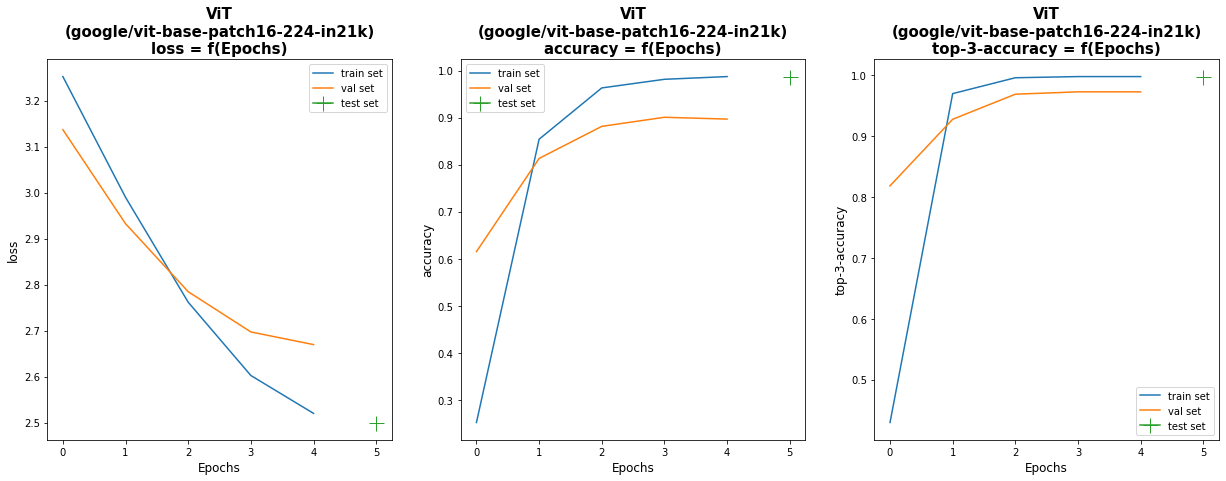

In [48]:
model_vit_eval, tps_test_vit = plot_loss_score(
#    model_vit_info, load_model(path_cache_output+'01_vit_best.h5'), [test_ds_prepro_vit_tf], [''], f'ViT\n({model_id})'
    model_vit_info, model_vit, [test_ds_prepro_vit_tf], [''], f'ViT\n({model_id})'
)
if sauvegarde_figure :
    plt.savefig(path_fig+'01_vit_plot_scores.png')

#### <u><b>e) Sauvegarde des performances</b></u>
On va créer un dictionnaire où seront sauvegardées les performances de ce modèle.

On prend également le soin de noter le nombre de poids de connexion à ré-apprendre (<i>Trainable params</i>) lors de la phase d'entraînement/validation, afin de pouvoir comparer les performances temporelles du modèles à celle de la baseline par la suite.

Pour cela, on utilise la fonction .summary du modèle entraîné.

In [49]:
model_vit.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  21532     
                                                                 
Total params: 85,820,188
Trainable params: 85,820,188
Non-trainable params: 0
_________________________________________________________________


In [60]:
if dossiers_b2d_chiens == "150_dogs_per_race/":
    model_vit_train_param = 85808653 
else :
    model_vit_train_param = 85820188 

In [61]:
dict_model(model_vit_info, tps_train_vit, model_vit_eval, tps_test_vit, model_vit_train_param, '01_vit_dict')

## <u><b>I.D - Analyse des résultats</b></u>

### <u><b>I.D.1 - Matrice de confusion</b></u>

In [52]:
# Vecteur des étiquettes réelles des images du test set
y_test = np.concatenate(
    [[
        img_class_labels[n] for n in elem[1]
    ] for elem in test_ds_prepro_vit_tf.as_numpy_iterator()]
)

In [53]:
# Prédictions sur le jeu de test
pred = model_vit.predict(x=test_ds_prepro_vit_tf)

33/33 [==============================] - 153s 5s/step


In [54]:
# Initialisation des dictionnaires qui enregistreront les proba de prédiction par étiquette
dico_pred = {'Vraie race': y_test}
# Construction de ce dictionnaire, clef=race étiquette, valeur=probabilité de prédiction par race
for n in range(len(img_class_labels)):
    dico_pred[img_class_labels[n]] = pred.logits[:, n]#/abs(pred.logits[:, n])
# Liste des Dataframes de proba(y_pred) = f(y_true)
df_pred = pd.DataFrame(data=dico_pred)
del dico_pred, n 

In [55]:
# Matrice des probabilité moyenne de prédiction entre races
mat_pred = df_pred.groupby('Vraie race').describe()[[(race, 'mean') for race in np.sort(img_class_labels)]]

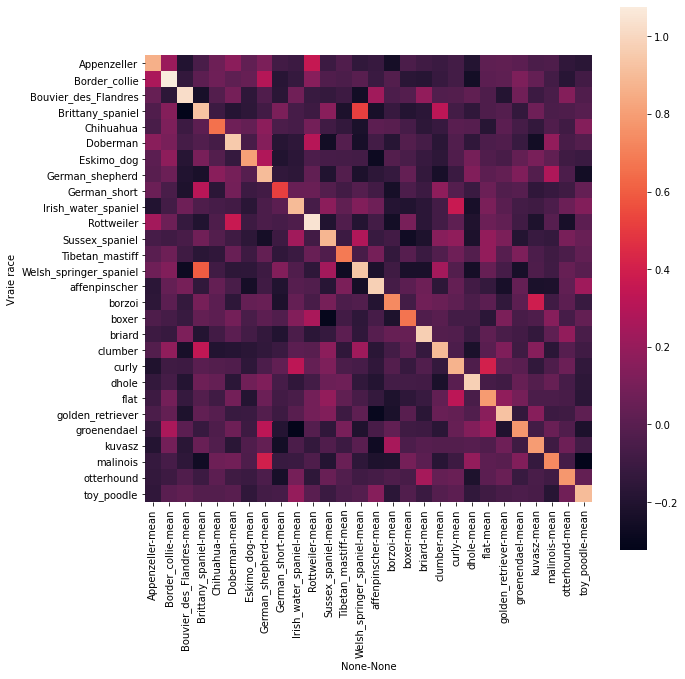

In [56]:
### Représentation graphique
plt.figure('Matrice de confusion adaptée à autant de races ', figsize=(10,10)), plt.clf()
axe = plt.subplot(111)
heatmap(data=mat_pred, ax=axe, square=True, annot=False)#, vmin=0, vmax=1)
if sauvegarde_figure:
    plt.savefig(path_fig+'01_vit_confusion_matrix.png')
del axe

On note cette bizarrerie : des valeurs négatives, impossible en théorie pour des probas. cela doit venir de la fonction d'activation de la couche dense de classification de TFViTForImageClassification.

In [62]:
# Affichage de la dernière couche dense
model_vit.layers[1]

Exactement, d'après la documentation (https://faroit.com/keras-docs/1.1.0/layers/core/), la fonction d'activation de base est une rampe linéaire, soit la fonction identité.

Mêmes si les coefficents diagnonaux de la matrice de confusion sont nettement plus forts que ceux hors diagonale, il nous faut faire l'effort de conversion (en ramenant l'échelle de variation à [0 , 1] afin de se rendre compte de l'ordre de grandeur des probabilité relatives.

In [64]:
from scipy.special import softmax

In [81]:
pred_ = softmax(pred.logits, axis=1)
# Initialisation des dictionnaires qui enregistreront les proba de prédiction par étiquette
dico_pred_ = {'Vraie race': y_test}
# Construction de ce dictionnaire, clef=race étiquette, valeur=probabilité de prédiction par race
for n in range(len(img_class_labels)):
    dico_pred_[img_class_labels[n]] = pred_[:, n]#/abs(pred.logits[:, n])
# Liste des Dataframes de proba(y_pred) = f(y_true)
df_pred_ = pd.DataFrame(data=dico_pred_)
del dico_pred_, n, pred_
# Matrice des probabilité moyenne de prédiction entre races
mat_pred_ = df_pred_.groupby('Vraie race').describe()[[(race, 'mean') for race in np.sort(img_class_labels)]]

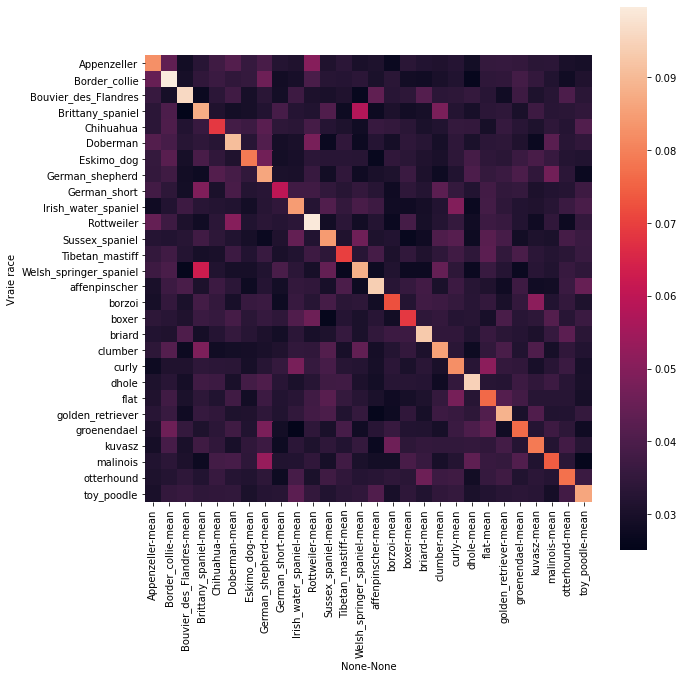

In [82]:
### Représentation graphique
plt.figure('Matrice de confusion après softmax', figsize=(10,10)), plt.clf()
axe = plt.subplot(111)
heatmap(data=mat_pred_, ax=axe, square=True, annot=False)#, vmin=0, vmax=1)
if sauvegarde_figure:
    plt.savefig(path_fig+'01_vit_confusion_matrix_softmax.png')
del axe

C'est déjà un peu plus contrasté. Nos prédictions ne sont pas si fortes que ça.

### <u><b>I.D.2 - Races de chiens mal-prédites</b></u>

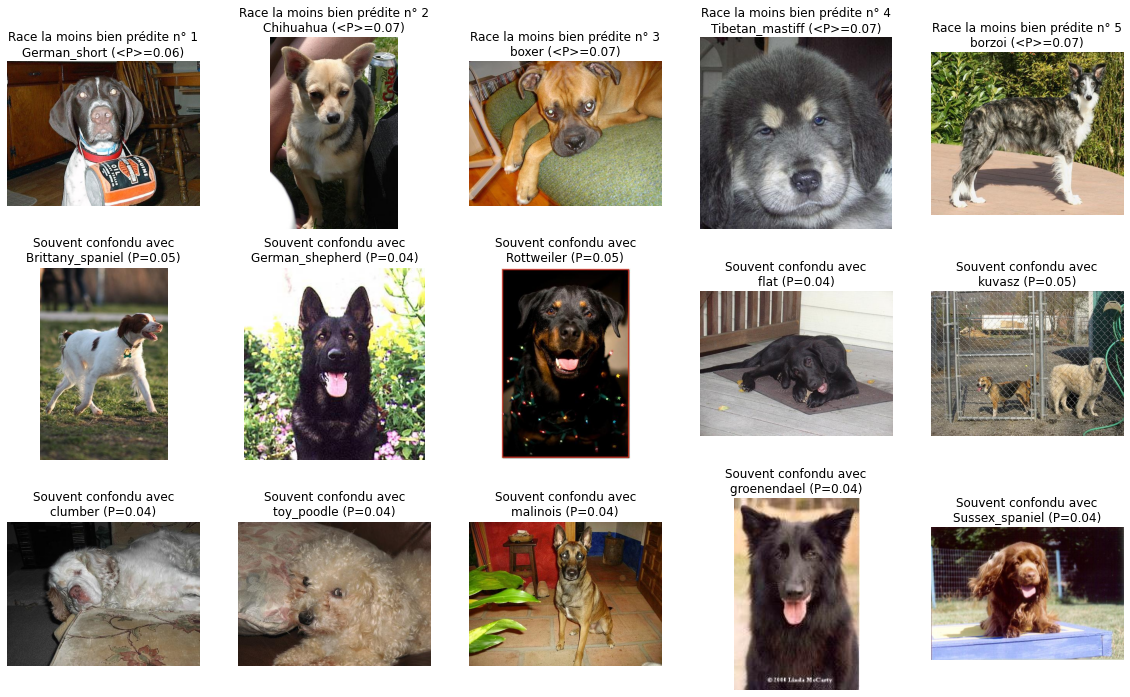

In [83]:
#tab_files_path[['collie' in path for path in tab_files_path]]
races = img_class_labels
### Graphe
plt.figure('Exemple des pires races en termes de prédiction', figsize=(4*5,4*3)), plt.clf()
for n, i in enumerate(mat_pred_.values.diagonal().argsort()[:5]):
    probas = mat_pred_.values[i]
    index_top_3 = probas.argsort()[-1:-4:-1][probas.argsort()[-1:-4:-1]!=i]
    # Cas particulier : race étiquette <=> j==0
    axe = plt.subplot(3, 5, n + 0*5 + 1)
    axe.set_title(f'Race la moins bien prédite n°{n+1 : >2}\n{np.sort(races)[i]} (<P>={probas[i]:>4.2f})') 
    with Image.open(test_path_files[test_path_files.apply(lambda x : np.sort(races)[i] in x)].iloc[0]) as img :
        axe.imshow(img), axe.axis('off')
    for j in range(1,3):
        k = index_top_3[j-1]
        axe = plt.subplot(3, 5, n + j*5 + 1)
        axe.set_title(f'Souvent confondu avec\n{np.sort(races)[k]} (P={probas[k]:>4.2f})')
#        with Image.open(tab_files_path[[np.sort(races)[k] in path for path in tab_files_path]][0]) as img :
        with Image.open(test_path_files[test_path_files.apply(lambda x : np.sort(races)[k] in x)].iloc[j]) as img :
            axe.imshow(img), axe.axis('off')
del k, j, i, probas, n, index_top_3, img
if sauvegarde_figure :
    plt.savefig(path_fig+'01_vit_worst_5.png')